In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

***Approach*** : 
-- 

-- ***Installing the libraries*** (because I am using kaggle kernel, all the libraries are already installed.

-- ***Importing all libraries***, as we I am doing image processing here, I will specially need to import keras and cv2 including the basic libraries

-- ***Data Augmentation*** - As we have almost 200 images, I will do data augmentation to increase the dataset and to generalize the data to avoid over-fitting.

--  will ***label*** the images in different folders as covid and normal

--  will ***split*** the data using sklearn

--  will ***display the sample images*** from both the categories

--  will ***define our CNN model*** with multiple convolution layers with different filter sizes

--  will ***train the model***

--  will plot the accuracy and loss scores

-- to make the model better we will try ***tuning the model*** and make mutiple models by adding/deleting cnn layers, changing filter sizes, adding drop out layers to get the best possible model


**Conclusion**
-- 

-- Because the augmentation was taking more time initially I tried using the original dataset for training but seeing that our model was over fitting, I augmenta


In [26]:
import numpy as np 
import pandas as pd 
import os
from os import listdir
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization,Flatten,Activation,Dense,MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle #shuffling the data improves the model


In [3]:
# image_dir="../input/covid19-image-dataset/Covid19-dataset/train"

In [4]:
# TRAIN_PATH = '../input/covid19-image-dataset/Covid19-dataset/train'
# VAL_PATH = '../input/covid19-image-dataset/Covid19-dataset/test'

In [5]:
# os.makedirs('../output/kaggle/working/augmented-images')
# os.makedirs('../output/kaggle/working/augmented-images/yes')
# os.makedirs('../output/kaggle/working/augmented-images/no')

In [6]:
# def augment_data(file_dir, n_generated_samples, save_to_dir):
#     data_gen = ImageDataGenerator(rotation_range=10, 
#                                   width_shift_range=0.1, 
#                                   height_shift_range=0.1, 
#                                   shear_range=0.1, 
#                                   brightness_range=(0.3, 1.0),
#                                   horizontal_flip=True, 
#                                   vertical_flip=True, 
#                                   fill_mode='nearest'
#                                  )

#     for filename in listdir(file_dir):
#         image = cv2.imread(file_dir + '/' + filename)
#         # reshape the image
#         image = image.reshape((1,)+image.shape)
#         save_prefix = 'aug_' + filename[:-4]
#         i=0
#         for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,save_prefix=save_prefix, save_format='jpg'):
#                 i += 1
#                 if i > n_generated_samples:
#                     break

In [7]:
# augmented_data_path ='../output/kaggle/working/augmented-images/'
# # augment data for the examples with label equal to 'yes' representing tumurous examples
# augment_data(file_dir=image_dir+'/Covid',n_generated_samples=2, save_to_dir=augmented_data_path+'yes')
# # augment data for the examples with label equal to 'no' representing non-tumurous examples
# augment_data(file_dir=image_dir+'/Normal', n_generated_samples=3, save_to_dir=augmented_data_path+'no')

In [6]:
def load_data(dir_list, image_size):

    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            image = cv2.imread(directory+'/'+filename)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-5:] == 'Covid':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
    
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [7]:
covid_yes = '../input/covid19-image-dataset/Covid19-dataset/train/Covid'
covid_no = '../input/covid19-image-dataset/Covid19-dataset/train/Normal'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([covid_yes, covid_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 181
X shape is: (181, 240, 240, 3)
y shape is: (181, 1)


In [10]:
def plot_sample_images(X, y, n=8):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 4
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(10, 8))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
        
        label_to_str = lambda label: "Positive" if label == 1 else "Negative"
        plt.suptitle(f"Covid: {label_to_str(label)}")
        plt.show()

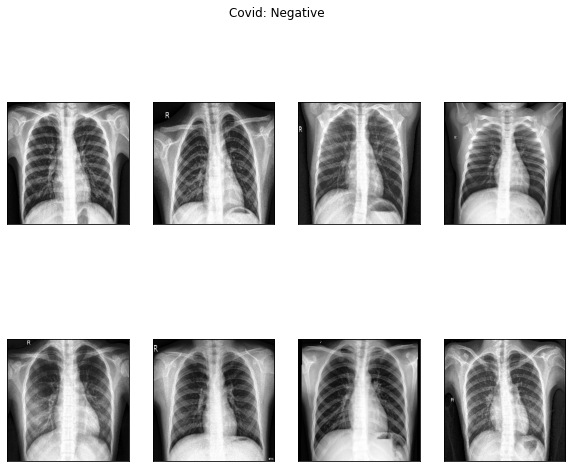

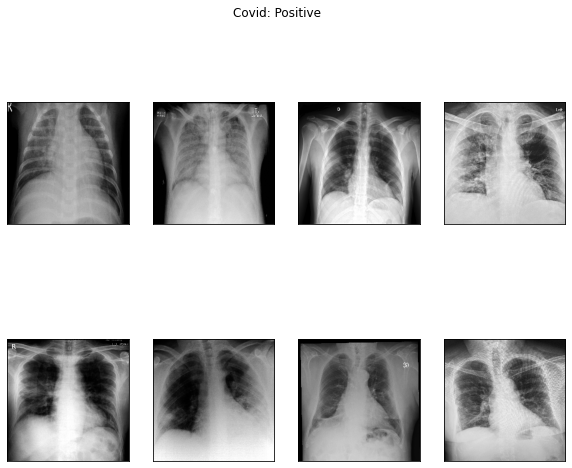

In [11]:
plot_sample_images(X, y)

In [12]:
def split_data(X, y, test_size=0.2):
       
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [14]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of validation examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))

number of training examples = 126
number of validation examples = 28
number of test examples = 27


In [47]:
# CNN based model in keras


def build_model(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), activation = 'relu')(X_input)
    X = Conv2D(32, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(64, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
    
#     X = Conv2D(128, (3, 3), activation = 'relu')(X)
#     X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)

    X = Flatten()(X) 
    X = Dense(64, activation='relu')(X) 
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X) 
    
    model = Model(inputs = X_input, outputs = X)
    
    return model    


In [48]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model=build_model(IMG_SHAPE)
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 236, 236, 32)      9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 118, 118, 32)      0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 118, 118, 32)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 58, 58, 64)       

In [49]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
4/4 [==============================] - 12s 3s/step - loss: 1.6532 - accuracy: 0.5794 - val_loss: 0.5375 - val_accuracy: 0.7143
Epoch 2/20
4/4 [==============================] - 11s 3s/step - loss: 0.8678 - accuracy: 0.6111 - val_loss: 0.7677 - val_accuracy: 0.2857
Epoch 3/20
4/4 [==============================] - 11s 3s/step - loss: 0.6031 - accuracy: 0.6667 - val_loss: 0.5961 - val_accuracy: 0.9286
Epoch 4/20
4/4 [==============================] - 11s 3s/step - loss: 0.3971 - accuracy: 0.8651 - val_loss: 0.5104 - val_accuracy: 0.8214
Epoch 5/20
4/4 [==============================] - 12s 3s/step - loss: 0.2622 - accuracy: 0.9048 - val_loss: 0.3054 - val_accuracy: 0.9643
Epoch 6/20
4/4 [==============================] - 11s 3s/step - loss: 0.2584 - accuracy: 0.9127 - val_loss: 0.2221 - val_accuracy: 0.9643
Epoch 7/20
4/4 [==============================] - 11s 3s/step - loss: 0.1323 - accuracy: 0.9603 - val_loss: 0.1696 - val_accuracy: 0.9643
Epoch 8/20
4/4 [==================

In [50]:
history = model.history.history

In [51]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']
    val_acc = history['val_accuracy']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

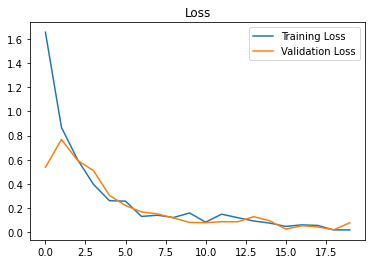

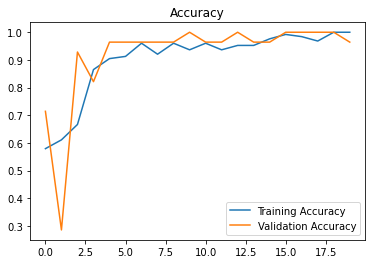

In [52]:
plot_metrics(history)

In [54]:
# CNN based model in keras


def build_model_1(input_shape):
    X_input = Input(input_shape)
    X = Conv2D(32, (3, 3), activation = 'relu')(X_input)
    X = Conv2D(32, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
    X = Conv2D(32, (3, 3), activation = 'relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Dropout(0.25)(X)
    
    
#     X = Conv2D(128, (3, 3), activation = 'relu')(X)
#     X = MaxPooling2D((2, 2))(X)
#     X = Dropout(0.25)(X)

    X = Flatten()(X) 
    X = Dense(64, activation='relu')(X) 
    X = Dropout(0.5)(X)
    X = Dense(1, activation='sigmoid')(X) 
    
    model_1 = Model_1(inputs = X_input, outputs = X)
    
    return model_1    

In [55]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)
model_1=build_model(IMG_SHAPE)
model_1.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 238, 238, 32)      896       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 236, 236, 32)      9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 118, 118, 32)      0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 118, 118, 32)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 116, 116, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 58, 58, 64)      

In [59]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.fit(x=X_train, y=y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
4/4 [==============================] - 11s 3s/step - loss: 1.2898 - accuracy: 0.4683 - val_loss: 0.6749 - val_accuracy: 0.3214
Epoch 2/20
4/4 [==============================] - 11s 3s/step - loss: 0.5697 - accuracy: 0.7222 - val_loss: 0.5802 - val_accuracy: 0.7143
Epoch 3/20
4/4 [==============================] - 11s 3s/step - loss: 0.3926 - accuracy: 0.8492 - val_loss: 0.4203 - val_accuracy: 0.8929
Epoch 4/20
4/4 [==============================] - 11s 3s/step - loss: 0.1821 - accuracy: 0.9365 - val_loss: 0.2467 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 11s 3s/step - loss: 0.2330 - accuracy: 0.9365 - val_loss: 0.1976 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 11s 3s/step - loss: 0.1353 - accuracy: 0.9444 - val_loss: 0.2552 - val_accuracy: 0.9643
Epoch 7/20
4/4 [==============================] - 11s 3s/step - loss: 0.2423 - accuracy: 0.9127 - val_loss: 0.1772 - val_accuracy: 0.9643
Epoch 8/20
4/4 [==================

In [61]:
history = model_1.history.history

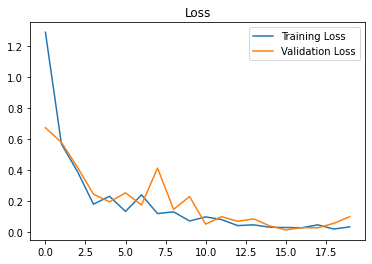

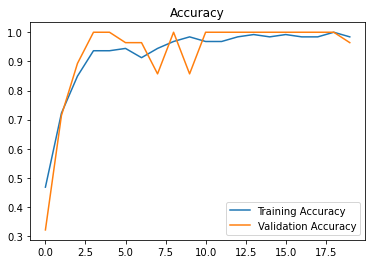

In [62]:
plot_metrics(history)